In [2]:
from pathlib import Path
from typing import Union, List
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
%matplotlib inline

change the base

In [42]:
BASE = Path("/Users/lynnricky/scripts/CDR-modelling-evaluation")
config = {
    "input": {
        "abymod": BASE.joinpath("output/run_profit_abpackingangle/abymod_nt"),
        "Rosetta": BASE.joinpath("output/run_profit_abpackingangle/rosetta_nt"),
        "IgFold": BASE.joinpath("output/run_profit_abpackingangle/IgFold"),
        "lyra": BASE.joinpath("output/run_profit_abpackingangle/lyra"),
    },
    "output": {
        "figures": BASE.joinpath("analysis/CDR/H3_figure/density"),
        "box": BASE.joinpath("analysis/CDR/H3_figure/boxplot")
    }
}

read in the length of H3 for different antibodies (change the name of file)

In [5]:
df = pd.read_excel("/Users/lynnricky/scripts/CDR-modelling-evaluation/analysis/CDR/CDRH3_length.xlsx")
df.head()

,abdbid,CDR-H3-legnth
0,7x1u_0,12
1,12e8_1,11
2,15c8_0,10
3,1a4j_1,10
4,1a4k_1,10


In [19]:
# extract RMSD, fitting region, fitting type from json file
def load_json_as_df(input_dir: Path, method_type: str = None):
    result = []  # "abdbid", "cdr", "rmsd", "fitting"
    json_fps = input_dir.glob(f"*.json")
    for file in os.listdir(input_dir):
        filename = os.path.basename(file).split(".")[0]
        if filename in list_s:
            with open(os.path.join(input_dir,file), "r") as f:
                data = json.load(f)
                abdbid = data["abdb_id"]
                for a, b, c in zip(data["cdr"], data["rmsd"], data["fitting"]):
                    result.append([abdbid, a, b, c])
    df = pd.DataFrame(result)
    df.columns = ["abdbid", "cdr", "rmsd", "fitting"]
    if method_type:
        df["method"] = [method_type] * df.shape[0]
    return df
df=load_json_as_df(config["input"]["abymod"], method_type="abYmod")
data_df = df[(df.cdr=="H3")  & (df.fitting=="local")][["abdbid", "rmsd"]]
#data_df.to_csv("/Users/lynnricky/Desktop/rmsd_mew.csv")

In [6]:
df_a = df.loc[df['CDR-H3-legnth'] <= 10]
df_b = df.loc[df['CDR-H3-legnth'] > 10]

list_s = df_a['abdbid'].tolist()
list_l = df_b['abdbid'].tolist()
print(len(list_s))
print(len(list_l))

447
594


## short CDRH3

In [8]:
# extract RMSD, fitting region, fitting type from json file
def load_json_as_df_s(input_dir: Path, method_type: str = None):
    result = []  # "abdbid", "cdr", "rmsd", "fitting"
    json_fps = input_dir.glob(f"*.json")
    for file in os.listdir(input_dir):
        filename = os.path.basename(file).split(".")[0]
        if filename in list_s:
            with open(os.path.join(input_dir,file), "r") as f:
                data = json.load(f)
                abdbid = data["abdb_id"]
                for a, b, c in zip(data["cdr"], data["rmsd"], data["fitting"]):
                    result.append([abdbid, a, b, c])
    df = pd.DataFrame(result)
    df.columns = ["abdbid", "cdr", "rmsd", "fitting"]
    if method_type:
        df["method"] = [method_type] * df.shape[0]
    return df


In [15]:
df = pd.concat([load_json_as_df_s(config["input"]["abymod"], method_type="abYmod"),
                load_json_as_df_s(config["input"]["lyra"], method_type="lyra"),
                load_json_as_df_s(config["input"]["IgFold"], method_type="IgFold"),
                load_json_as_df_s(config["input"]["Rosetta"], method_type="Rosetta")], axis=0)
df.reset_index(drop=True, inplace=True)

In [16]:
len(df["abdbid"].unique())

422

In [18]:
# plot
def plot_fitting(data: pd.DataFrame,
                 fitting_type: str, rmsd_cutoff: float = None,
                 save_fig: bool = False, out_dir: Path = None,
                 transparent: bool = True):
    assert fitting_type in ("global", "local")
    if not rmsd_cutoff:
        rmsd_cutoff = 8.0
    cdrs = ("L1", "L2", "L3", "H1", "H2", "H3")
    fig, ax = plt.subplots()

    data_df = df[(df.cdr=="H3") & (df.rmsd < rmsd_cutoff) & (df.fitting==fitting_type)][["rmsd", "method"]]
    sns.kdeplot(data=data_df, x="rmsd", hue="method", ax=ax, common_norm=False)
    # beautify
    ax.set_xlim(0, rmsd_cutoff)
    # show tick and tick labels even with sharex=True
    ax.tick_params(axis="x", bottom=True, labelbottom=True)
    ax.tick_params(axis="y", left=True, labelleft=True)

    # title
    sample_size = data_df.groupby("method").count().iloc[:, 0].to_dict()
    abymod_size = sample_size["abYmod"]
    igfold_size = sample_size["IgFold"]
    lyra_size = sample_size["lyra"]
    rosetta_size = sample_size["Rosetta"]
    ax.set_title(f"H3, size - abYmod: {abymod_size}, IgFold: {igfold_size}, lyra: {lyra_size}, Rosetta:{rosetta_size}")
        # grid
    ax.grid(alpha=0.3)
    fig_title = f"{fitting_type[0].upper()+fitting_type[1:]} fitting " + \
                r"($\mathrm{C_\alpha RMSD\ <}$" + \
                f"{rmsd_cutoff }" + \
                r"$\mathrm{\AA})$"
    fig.suptitle(fig_title, fontsize=14)
    fig.tight_layout()
    plt.show()

    if save_fig:
        if not out_dir:
            out_dir = Path(".")
        fn = f"{fitting_type}-rmsd_thr{rmsd_cutoff:.0f}"
        #fig.savefig(out_dir.joinpath(f"{fn}_s.png"), dpi=300, transparent=transparent)
        fig.savefig(out_dir.joinpath(f"{fn}_s.pdf"), transparent=transparent)

In [19]:
# plot
def plot_fitting_ylim(data: pd.DataFrame,
                 fitting_type: str, rmsd_cutoff: float = None,
                 save_fig: bool = False, out_dir: Path = None,
                 transparent: bool = True, ylim: float = None):
    assert fitting_type in ("global", "local")
    if not rmsd_cutoff:
        rmsd_cutoff = 8.0
    cdrs = ("L1", "L2", "L3", "H1", "H2", "H3")
    fig, ax = plt.subplots()

    data_df = df[(df.cdr=="H3") & (df.rmsd < rmsd_cutoff) & (df.fitting==fitting_type)][["rmsd", "method"]]
    sns.kdeplot(data=data_df, x="rmsd", hue="method", ax=ax, common_norm=False)
    # beautify
    ax.set_xlim(0, rmsd_cutoff)
    # show tick and tick labels even with sharex=True
    ax.tick_params(axis="x", bottom=True, labelbottom=True)
    ax.tick_params(axis="y", left=True, labelleft=True)
    ax.set_ylim(0,ylim)
    # title
    sample_size = data_df.groupby("method").count().iloc[:, 0].to_dict()
    abymod_size = sample_size["abYmod"]
    igfold_size = sample_size["IgFold"]
    lyra_size = sample_size["lyra"]
    rosetta_size = sample_size["Rosetta"]
    ax.set_title(f"H3, size - abYmod: {abymod_size}, IgFold: {igfold_size}, lyra: {lyra_size}, Rosetta:{rosetta_size}")
        # grid
    ax.grid(alpha=0.3)
    fig_title = f"{fitting_type[0].upper()+fitting_type[1:]} fitting " + \
                r"($\mathrm{C_\alpha RMSD\ <}$" + \
                f"{rmsd_cutoff }" + \
                r"$\mathrm{\AA})$"
    fig.suptitle(fig_title, fontsize=14)
    fig.tight_layout()
    plt.show()

    if save_fig:
        if not out_dir:
            out_dir = Path(".")
        fn = f"{fitting_type}-rmsd_thr{rmsd_cutoff:.0f}"
        #fig.savefig(out_dir.joinpath(f"{fn}_s.png"), dpi=300, transparent=transparent)
        fig.savefig(out_dir.joinpath(f"{fn}_s.pdf"), transparent=transparent)

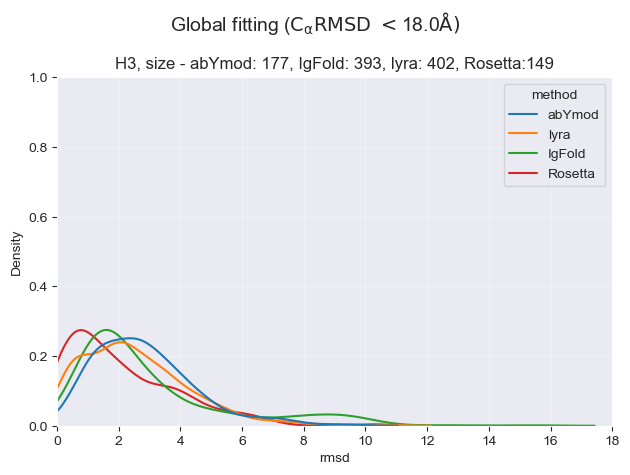

In [20]:
# global fitting, rmsd cutoff = 8.0
plot_fitting_ylim(data=df, fitting_type="global", rmsd_cutoff=18.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False, ylim=1)

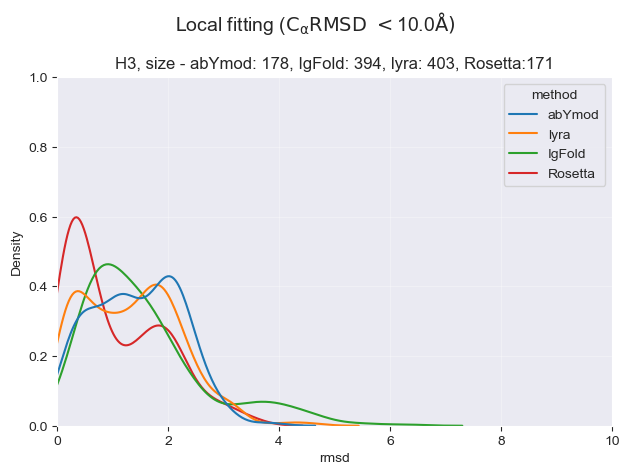

In [21]:
# global fitting, rmsd cutoff = 8.0
plot_fitting_ylim(data=df, fitting_type="local", rmsd_cutoff=10.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False, ylim=1)

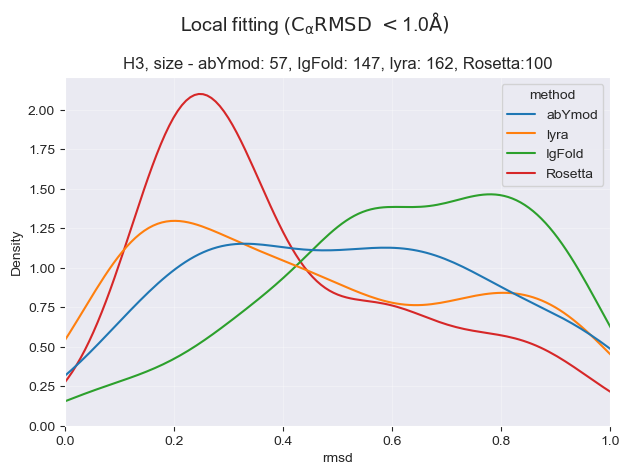

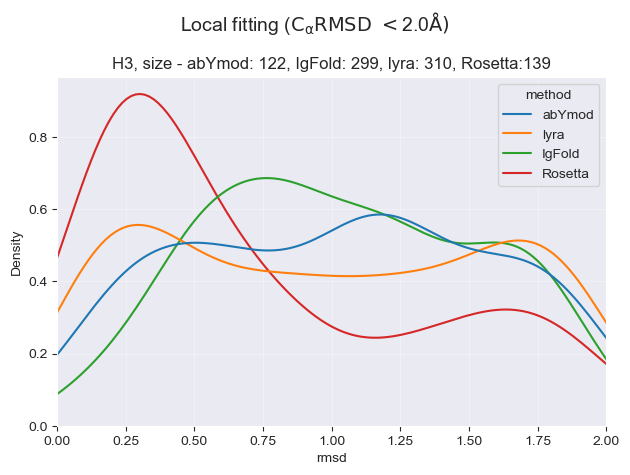

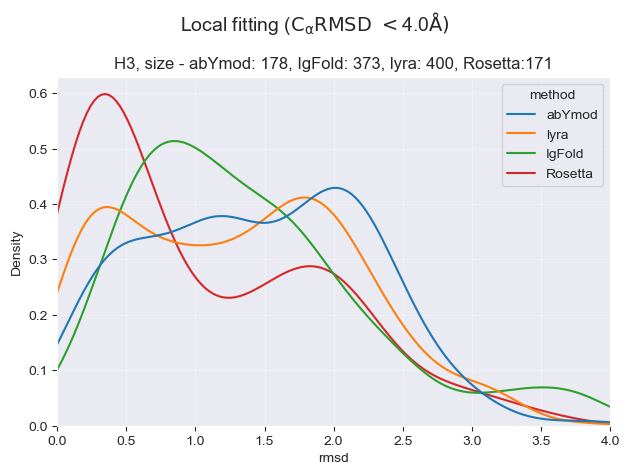

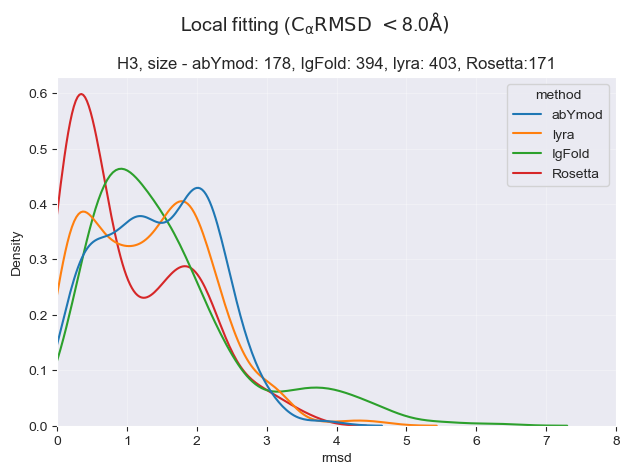

In [22]:
# local fitting, rmsd cutoff = 1.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=1.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 2.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=2.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 4.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=4.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 8.0
plot_fitting(data=df, fitting_type="local", rmsd_cutoff=8.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)

## long CDRH3

In [23]:
# extract RMSD, fitting region, fitting type from json file
def load_json_as_df_l(input_dir: Path, method_type: str = None):
    result = []  # "abdbid", "cdr", "rmsd", "fitting"
    json_fps = input_dir.glob(f"*.json")
    for file in os.listdir(input_dir):
        filename = os.path.basename(file).split(".")[0]
        if filename in list_l:
            with open(os.path.join(input_dir, file), "r") as f:
                data = json.load(f)
                abdbid = data["abdb_id"]
                for a, b, c in zip(data["cdr"], data["rmsd"], data["fitting"]):
                    result.append([abdbid, a, b, c])
    df = pd.DataFrame(result)
    df.columns = ["abdbid", "cdr", "rmsd", "fitting"]
    if method_type:
        df["method"] = [method_type] * df.shape[0]
    return df


df_l = pd.concat([load_json_as_df_l(config["input"]["abymod"], method_type="abYmod"),
                load_json_as_df_l(config["input"]["lyra"], method_type="lyra"),
                load_json_as_df_l(config["input"]["IgFold"], method_type="IgFold"),
                load_json_as_df_l(config["input"]["Rosetta"], method_type="Rosetta")], axis=0)
df_l.reset_index(drop=True, inplace=True)
len(df_l["abdbid"].unique())

507

In [24]:
# plot
def plot_fitting_l(data: pd.DataFrame,
                 fitting_type: str, rmsd_cutoff: float = None,
                 save_fig: bool = False, out_dir: Path = None,
                 transparent: bool = True, ylim: float=None):
    assert fitting_type in ("global", "local")
    if not rmsd_cutoff:
        rmsd_cutoff = 8.0

    fig, ax = plt.subplots()
    data_df = data[(data.cdr=="H3") & (data.rmsd < rmsd_cutoff) & (data.fitting==fitting_type)][["rmsd", "method"]]

    sns.kdeplot(data=data_df, x="rmsd", hue="method", ax=ax, common_norm=False)
    # beautify
    ax.set_xlim(0, rmsd_cutoff)
    # show tick and tick labels even with sharex=True
    ax.set_ylim(0,ylim)
    ax.tick_params(axis="x", bottom=True, labelbottom=True)
    ax.tick_params(axis="y", left=True, labelleft=True)
    # title
    sample_size = data_df.groupby("method").count().iloc[:, 0].to_dict()
    abymod_size = sample_size["abYmod"]
    igfold_size = sample_size["IgFold"]
    lyra_size = sample_size["lyra"]
    rosetta_size = sample_size["Rosetta"]
    ax.set_title(f"H3, size - abYmod: {abymod_size}, IgFold: {igfold_size}, lyra: {lyra_size}, rosetta:{rosetta_size}")
    # grid
    ax.grid(alpha=0.3)
    fig_title = f"{fitting_type[0].upper()+fitting_type[1:]} fitting " + \
                r"($\mathrm{C_\alpha RMSD\ <}$" + \
                f"{rmsd_cutoff }" + \
                r"$\mathrm{\AA})$"
    fig.suptitle(fig_title, fontsize=14)
    fig.tight_layout()
    plt.show()

    if save_fig:
        if not out_dir:
            out_dir = Path(".")
        fn = f"{fitting_type}-rmsd_thr{rmsd_cutoff:.0f}"
        fig.savefig(out_dir.joinpath(f"{fn}_l.png"), dpi=300, transparent=transparent)
        fig.savefig(out_dir.joinpath(f"{fn}_l.pdf"), transparent=transparent)

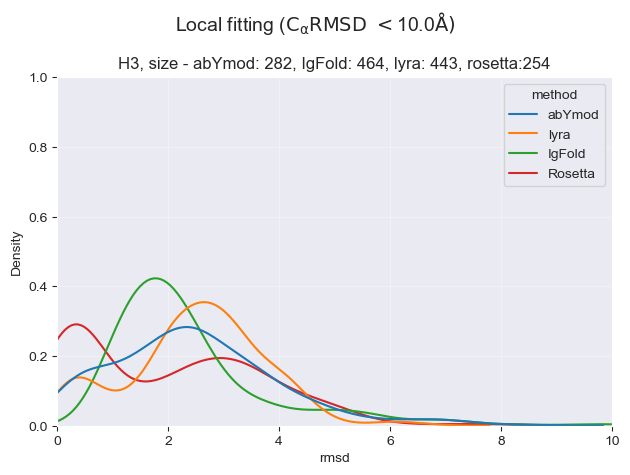

In [25]:
plot_fitting_l(data=df_l, fitting_type="local", rmsd_cutoff=10.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False, ylim=1)

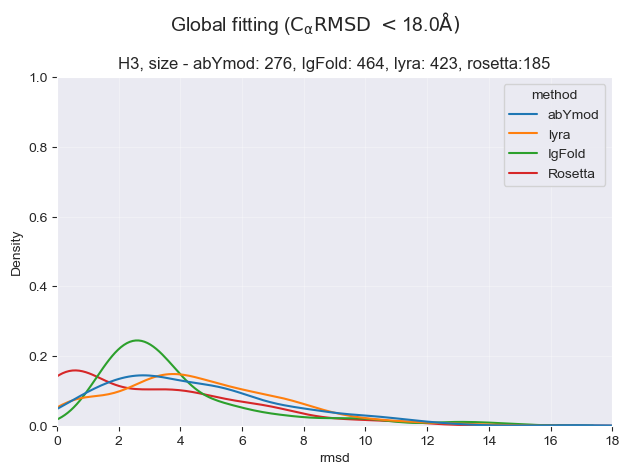

In [26]:
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=18.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False, ylim=1)

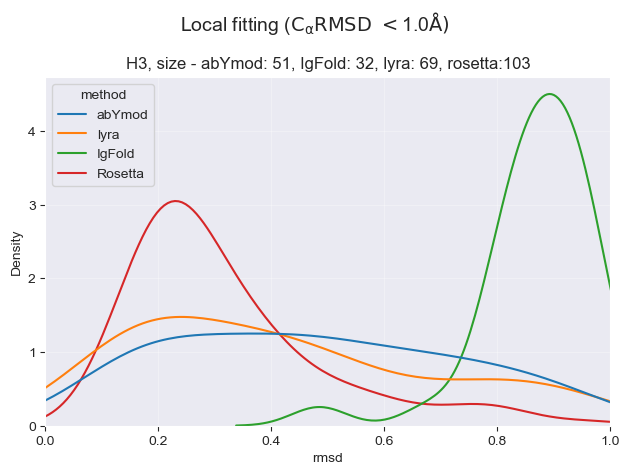

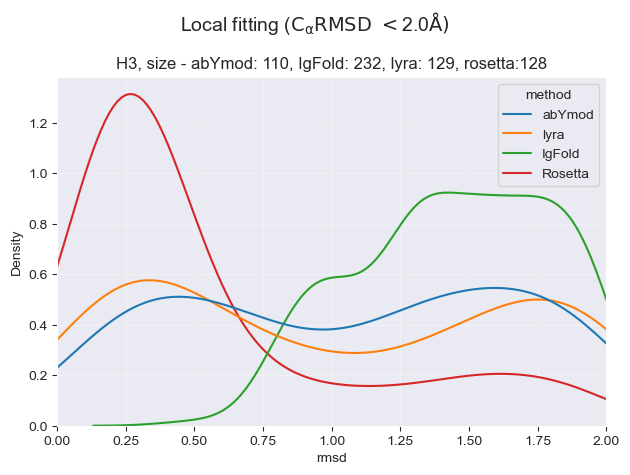

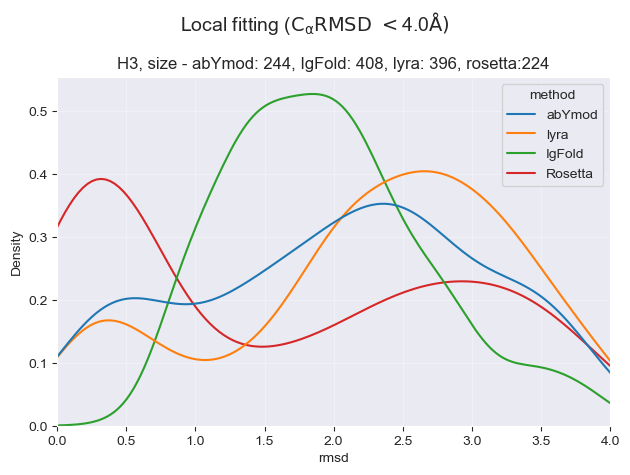

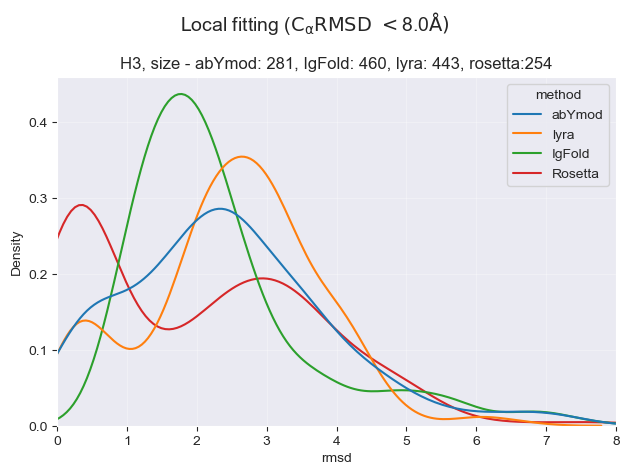

In [27]:
# local fitting, rmsd cutoff = 1.0
plot_fitting_l(data=df_l, fitting_type="local", rmsd_cutoff=1.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 2.0
plot_fitting_l(data=df_l, fitting_type="local", rmsd_cutoff=2.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 4.0
plot_fitting_l(data=df_l, fitting_type="local", rmsd_cutoff=4.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 8.0
plot_fitting_l(data=df_l, fitting_type="local", rmsd_cutoff=8.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)

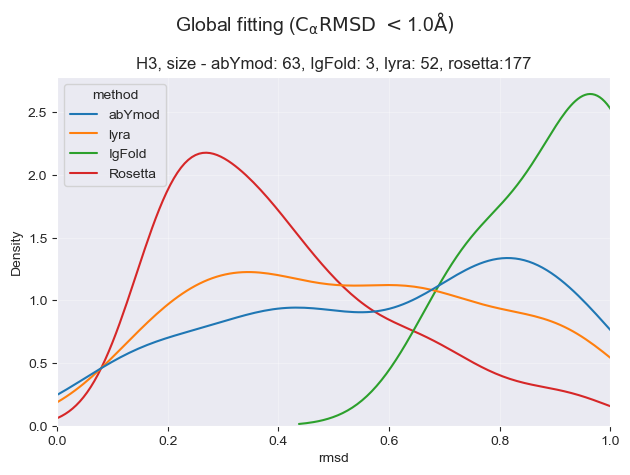

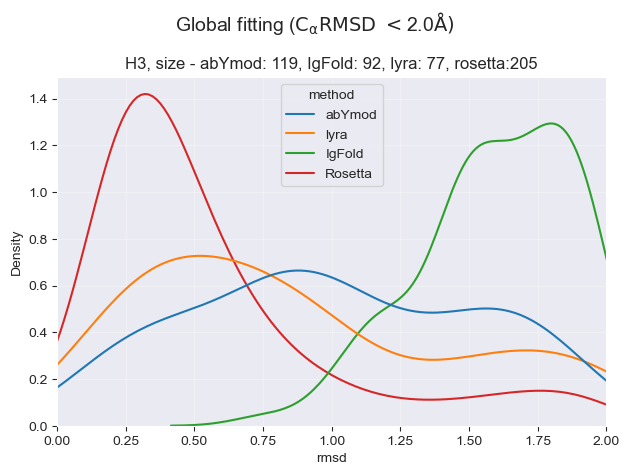

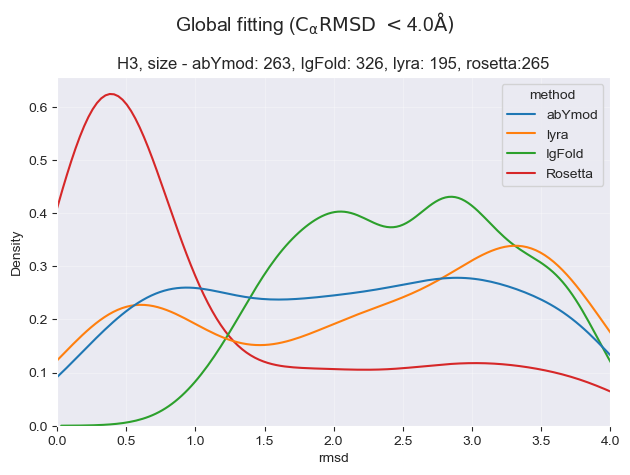

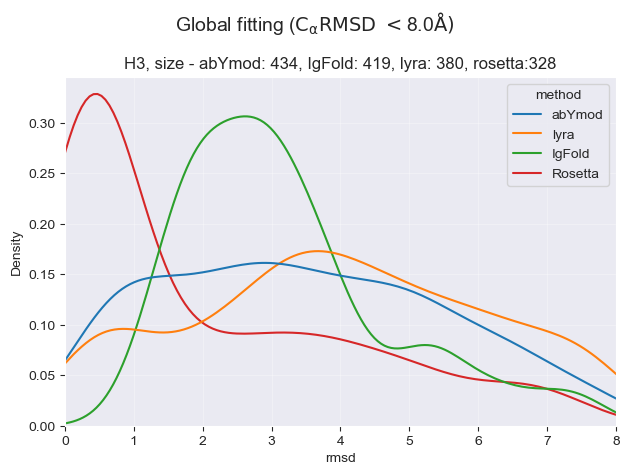

In [15]:
# local fitting, rmsd cutoff = 1.0
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=1.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 2.0
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=2.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 4.0
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=4.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)
# local fitting, rmsd cutoff = 8.0
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=8.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)


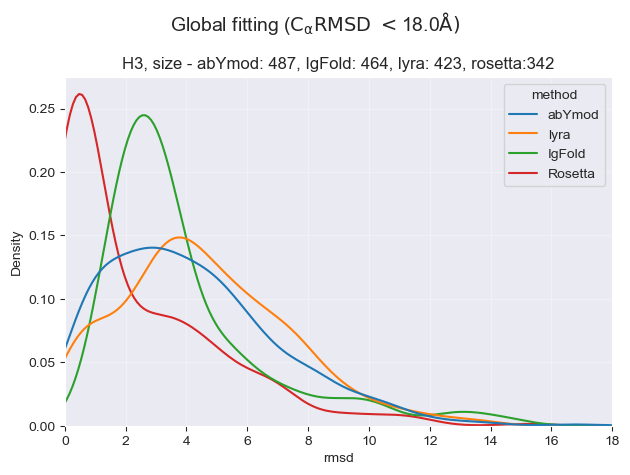

In [20]:
# local fitting, rmsd cutoff = 8.0
plot_fitting_l(data=df_l, fitting_type="global", rmsd_cutoff=18.0, save_fig=True, out_dir=config["output"]["figures"], transparent=False)

## box plot

In [28]:
df_abymod = df[df['method'] == "abYmod"]
df_abymod = df_abymod.rename(columns={'rmsd': 'abYmod_rmsd'})
df_abymod =df_abymod.drop("method", axis=1)
df_lyra = df[df['method'] == "lyra"]
df_lyra = df_lyra.rename(columns={'rmsd': 'lyra_rmsd'})
df_lyra=df_lyra.drop("method", axis=1)
df_IgFold = df[df['method'] == "IgFold"]
df_IgFold = df_IgFold.rename(columns={'rmsd': 'IgFold_rmsd'})
df_IgFold=df_IgFold.drop("method", axis=1)
df_Rosetta = df[df['method'] == "Rosetta"]
df_Rosetta = df_Rosetta.rename(columns={'rmsd': 'Rosetta_rmsd'})
df_Rosetta=df_Rosetta.drop("method", axis=1)

In [37]:
df_abymod.head()

,abdbid,cdr,abYmod_rmsd,fitting
0,3o6k_0,H1,0.665,local
1,3o6k_0,H2,0.272,local
2,3o6k_0,H3,1.485,local
3,3o6k_0,L1,0.243,local
4,3o6k_0,L2,0.271,local


In [43]:
df_lyra.head()

,abdbid,cdr,lyra_rmsd,fitting
5776,3o6k_0,H1,0.103,local
5777,3o6k_0,H2,0.162,local
5778,3o6k_0,H3,0.175,local
5779,3o6k_0,L1,0.416,local
5780,3o6k_0,L2,0.171,local


In [29]:
merged_df = pd.merge(df_abymod, df_lyra, on=['abdbid', 'cdr', 'fitting'])
merged_df = pd.merge(merged_df, df_IgFold, on=['abdbid', 'cdr', 'fitting'])
merged_df = pd.merge(merged_df, df_Rosetta, on=['abdbid', 'cdr', 'fitting'])


In [30]:
merged_df=merged_df[merged_df["cdr"]=="H3"]
merged_df

,abdbid,cdr,abYmod_rmsd,fitting,lyra_rmsd,IgFold_rmsd,Rosetta_rmsd
2,6uy3_0,H3,1.867,local,1.882,0.788,1.842
8,6lun_0,H3,2.060,local,1.467,2.341,2.082
15,6lun_0,H3,2.712,global,1.896,5.272,2.577
22,7v3q_1,H3,1.288,local,1.665,0.359,0.635
29,7v3q_1,H3,2.275,global,2.566,0.644,1.091
...,...,...,...,...,...,...,...
1983,6o8d_1,H3,6.920,global,5.838,9.846,6.070
1990,5b6f_1,H3,2.087,local,1.827,2.430,2.009
1997,5b6f_1,H3,6.069,global,4.231,4.888,6.500
2004,4lly_1,H3,1.217,local,1.393,1.772,0.198


In [31]:
df_abymod = df[df['method'] == "abYmod"]

In [32]:
df_l.head()

,abdbid,cdr,rmsd,fitting,method
0,6mee_1,H1,3.317,local,abYmod
1,6mee_1,H2,2.178,local,abYmod
2,6mee_1,H3,5.326,local,abYmod
3,6mee_1,L1,0.491,local,abYmod
4,6mee_1,L2,0.101,local,abYmod


In [35]:
df["len"]="s"
df_l["len"]="l"

In [36]:
df_1=pd.concat([df, df_l], ignore_index=True)
df_global=df_1[(df_1.cdr=="H3") & (df_1.fitting=="global")]

In [37]:
import seaborn as sns

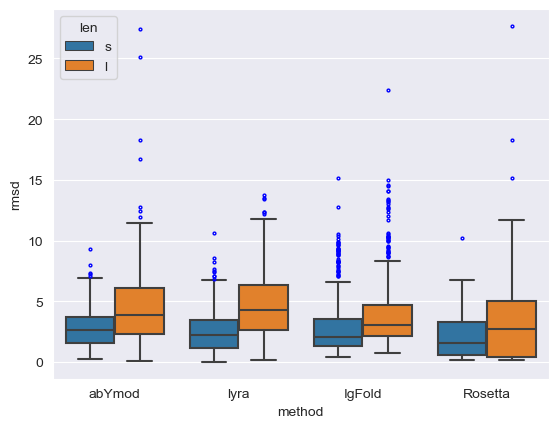

In [43]:
flierprops = dict(marker='o', markerfacecolor='None', markersize=2,  markeredgecolor='blue')
compare=sns.boxplot(x="method", y="rmsd",
            hue="len",
            data=df_global, showfliers = True, flierprops=flierprops)
compare.set_ylabel("rmsd")
plt.savefig(config["output"]["box"].joinpath(f"global_outlier.pdf"))

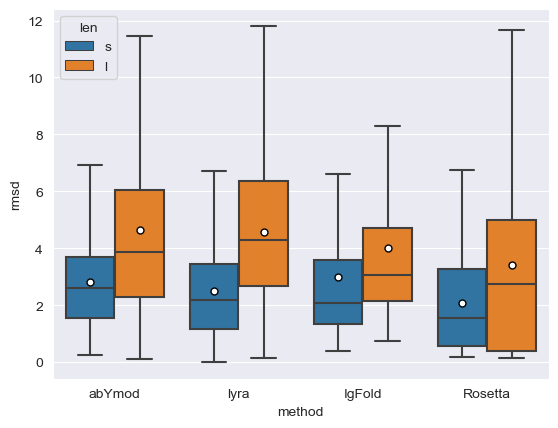

In [44]:
compare=sns.boxplot(x="method", y="rmsd",
            hue="len",
            data=df_global, showfliers = False,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.savefig(config["output"]["box"].joinpath(f"global.pdf"))

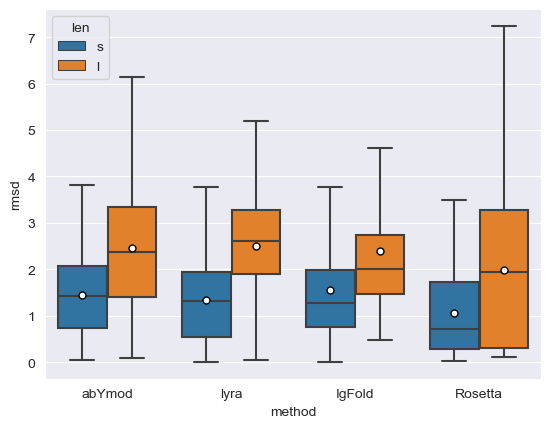

In [46]:
df_1=pd.concat([df, df_l], ignore_index=True)
df_local=df_1[(df_1.cdr=="H3") & (df_1.fitting=="local")]

compare = sns.boxplot(x="method", y="rmsd",
                      hue="len",
                      data=df_local, showfliers=False, showmeans=True, meanprops={"marker": "o",
                                                                              "markerfacecolor": "white",
                                                                              "markeredgecolor": "black",
                                                                              "markersize": "5"})
plt.savefig(config["output"]["box"].joinpath(f"local.pdf"))

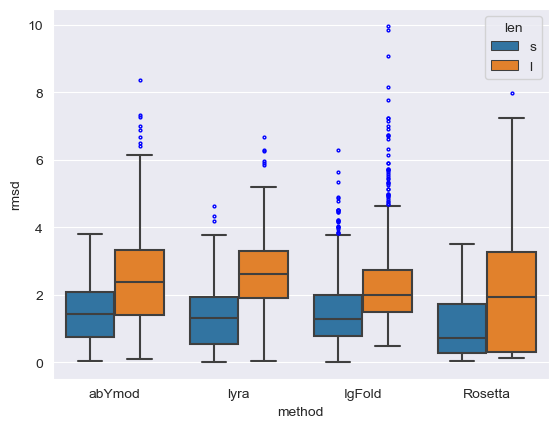

In [47]:
flierprops = dict(marker='o', markerfacecolor='None', markersize=2, markeredgecolor='blue')
compare = sns.boxplot(x="method", y="rmsd",
                      hue="len",
                      data=df_local, showfliers=True, flierprops=flierprops)
compare.set_ylabel("rmsd")
plt.savefig(config["output"]["box"].joinpath(f"local_outlier.pdf"))